# split training queries by teacher model performance

In [7]:
import os
import gzip
import pickle
data_folder = '../../msmarco'

ce_scores_file = os.path.join(data_folder, 'cross-encoder-ms-marco-MiniLM-L-6-v2-scores.pkl.gz')

with gzip.open(ce_scores_file, 'rb') as fIn:
    ce_scores = pickle.load(fIn)

In [2]:
qrel_file = f"../../msmarco/qrels.train.tsv"
from collections import defaultdict
qrels = defaultdict(dict)
with open(qrel_file) as f:
    for line in f:
        try:
            qid, _, did, rel = line.strip().split("\t")
        except:
            qid, _, did, rel = line.strip().split(" ")
        if int(rel) > 0:
            qrels[qid][did] = int(rel)

In [3]:
import pytrec_eval
from statistics import mean
import scipy.stats as stats
from collections import defaultdict
VALIDATION_METRIC = 'recip_rank' 

trec_eval = pytrec_eval.RelevanceEvaluator(qrels, {VALIDATION_METRIC})

In [4]:
good_q = []
bad_q = []

for q in ce_scores:
    ce_scores_str = defaultdict(dict)
    ce_scores_str[str(q)] = {str(d): ce_scores[q][d] for d in ce_scores[q]}
    eval_scores_teacher = trec_eval.evaluate(ce_scores_str)
    if len(eval_scores_teacher) == 0:
        continue
    if eval_scores_teacher[str(q)][VALIDATION_METRIC] >= 0.5:
        good_q.append(str(q))
    elif eval_scores_teacher[str(q)][VALIDATION_METRIC] < 0.3 and eval_scores_teacher[str(q)][VALIDATION_METRIC] > 0.01:
        bad_q.append(str(q))

good_q = set(good_q)
bad_q = set(bad_q)

In [5]:
del qrels

In [9]:
import json
open("../msmarco/teacher_good_q_0.5.json", "w").write(json.dumps(list(good_q)))
open("../msmarco/teacher_bad_q_0.3.json", "w").write(json.dumps(list(bad_q)))

2506701

## generate gradient

In [1]:
import json
bad_q = set(json.loads(open("../msmarco/teacher_good_q_0.5.json").readline()))

In [2]:
import tqdm
import json
train_query_file = "../../msmarco/training_queries/train_queries_distill_splade_colbert_0.json"
#train_queries_good = dict()
train_queries_bad = dict()

with open(train_query_file) as f: #training_queries_splade_max_156000_ceclean.json
    for line in tqdm.tqdm(f):
        qid = line.split("\t")[0]
        '''
        if qid in good_q:
            train_queries_good[qid] = json.loads(line.split("\t")[1])

            train_queries_good[qid]['neg'] = [x for x in train_queries_good[qid]['neg'] if x[0] <= 20]
            if len(train_queries_good[line.split("\t")[0]]['neg']) == 0:
                del train_queries_good[line.split("\t")[0]]
                continue
        '''
        if qid in bad_q:
            train_queries_bad[qid] = json.loads(line.split("\t")[1])

            train_queries_bad[qid]['neg'] = [x for x in train_queries_bad[qid]['neg'] if x[0] <= 20]
            if len(train_queries_bad[line.split("\t")[0]]['neg']) == 0:
                del train_queries_bad[line.split("\t")[0]]
                continue


502937it [00:14, 33628.23it/s]


In [3]:
#FROM Sentence-BERT(https://github.com/UKPLab/sentence-transformers/blob/afee883a17ab039120783fd0cffe09ea979233cf/examples/training/ms_marco/train_bi-encoder_margin-mse.py) with minimal changes.
#Original License Apache2, NOTE: Trained MSMARCO models are NonCommercial (from dataset License)

import sys
import json
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, evaluation, InputExample
from sbert import SentenceTransformerA
import models
import logging
from datetime import datetime
import gzip
import os
import tarfile
import tqdm
from torch.utils.data import Dataset
import random
from shutil import copyfile
import pickle
import argparse
import losses
import torch
from collections import defaultdict
from data import MSMARCODataset
from evaluate_training import evaluate_trainining
import transformers
#from colbert_model import DETeacher


data_folder = '../../msmarco'

#### Read the corpus file containing all the passages. Store them in the corpus dict
corpus = {}  # dict in the format: passage_id -> passage. Stores all existing passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')


with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

### Read the train queries, store in queries dict

queries = {}  # dict in the format: query_id -> query. Stores all training queries
queries_filepath = os.path.join(data_folder, 'queries.train.tsv')

with open(queries_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        qid, query = line.strip().split("\t")
        qid = int(qid)
        queries[qid] = query

        
ce_scores_file = os.path.join(data_folder, 'cross-encoder-ms-marco-MiniLM-L-6-v2-scores.pkl.gz')

with gzip.open(ce_scores_file, 'rb') as fIn:
    ce_scores = pickle.load(fIn)

In [4]:
#model_name = "output/colbert_splade_distill_num1_kldiv_position_mrr_diff_alpha0.0_denoiseFalse_num20_kldiv_position5-lr1e-05-batch_size_8x4-2022-10-22/100000/0_ColBERTTransformer"
#model_name = "output/colbert_splade_distill_num1_kldiv_focal_default_gamma5.0_denoiseFalse_num20_kldiv_focal5-lr1e-05-batch_size_8x4-2022-10-30/100000/0_ColBERTTransformer"

#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-10/10/0_ColBERTTransformer"
#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-09/1000/0_ColBERTTransformer"

#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-10/10/0_ColBERTTransformer"

model_name = "output/colbert_splade_distill_num1_kldiv_multipos_focal_default_alpha0.2_denoiseFalse_num20_kldiv_multipos_focal5-lr1e-05-batch_size_8x4-2022-11-09/10000/0_ColBERTTransformer"
#model_name = "output/colbert_splade_distill_num1_kldiv_multipos_default_alpha0.2_denoiseFalse_num20_kldiv_multipos5-lr1e-05-batch_size_8x4-2022-11-09/10000/0_ColBERTTransformer"



word_embedding_model = models.ColBERTTransformer(model_name, max_seq_length=256)
checkpoint = torch.load(os.path.join(model_name, "checkpoint.pt"), map_location='cpu')
word_embedding_model.load_state_dict(checkpoint)
word_embedding_model.to('cuda')
model = SentenceTransformerA(modules=[word_embedding_model])


In [5]:
# For training the SentenceTransformer model, we need a dataset, a dataloader, and a loss used for training.
train_dataset = MSMARCODataset(queries=train_queries_bad, corpus=corpus, ce_scores=ce_scores, loss_type="kldiv_focal", num_neg=5, topk = 20)
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=4, drop_last=True)
train_dataloader.collate_fn = model.smart_batching_collate
data_iterator = iter(train_dataloader)

In [6]:

#train_loss = losses.KLDivLossColBERT(model=model)
train_loss = losses.KLDivLossColBERT(model=model, focal=True, gamma = 5.0)
'''
elif args.loss_type == 'kldiv_ib':
    train_loss = losses.KLDivLossColBERTInBatch(model=model, inbatch_p = args.ib_p)
elif args.loss_type == "kldiv_focal":
    train_loss = losses.KLDivLossColBERT(model=model, focal=True, gamma = args.gamma)
elif args.loss_type == "kldiv_position_focal":
    train_loss = losses.KLDivLossColBERT(model=model, scaled = True, focal=True, gamma = args.gamma, alpha = args.alpha)
else:
    raise "Unknown loss!"
'''
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
param_optimizer = list(train_loss.named_parameters())
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
train_loss.train()

KLDivLossColBERT(
  (model): SentenceTransformerA(
    (0): MLMTransformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: DataParallel 
  )
  (loss_fct): KLDivLoss()
)

In [7]:
gradients = []
i = 0
for data in tqdm.tqdm(data_iterator):
    train_loss.zero_grad()
    if i == 10000:
        break
    i += 1
    features, labels = data
    loss_value = train_loss(features, labels)
    loss_value.backward()
    gradients.append(model[0].linear.weight.grad.norm(2).tolist())

  0%|                                                                                                                                                                    | 0/46550 [00:00<?, ?it/s]/home/ec2-user/efs/splade_cls/training_with_sentence_transformers/data.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  target_score = torch.nn.functional.log_softmax(target_score)
 21%|████████████████████████████████▏                                                                                                                     | 10000/46550 [33:34<2:02:41,  4.96it/s]


In [8]:
open("gradient_klfr_10k_temp_good_sample10k.json","w").write(json.dumps(gradients))
#open("gradient_klfr2.0_1k_good_sample1000.json","w").write(json.dumps(gradients))

213499

In [6]:
loss_value

NameError: name 'loss_value' is not defined

## plot

In [2]:
import json
grad_kldiv = json.loads(open("gradient_kldiv_1k_good_sample10k.json").readline())
#grad_kldiv = gradients
grad_klfr = json.loads(open("gradient_klfr_1k_good_sample10k.json").readline())
grad_kldivg = json.loads(open("gradient_kldiv_100k_good_sample1000.json").readline())
grad_klfrg = json.loads(open("gradient_klfr_100k_good_sample1000.json").readline())

FileNotFoundError: [Errno 2] No such file or directory: 'gradient_kldiv_1k_good_sample10k.json'

In [15]:
np.mean(grad_kldiv)

0.22531698748264462

In [16]:
np.mean(grad_klfr)

0.061464603052187455

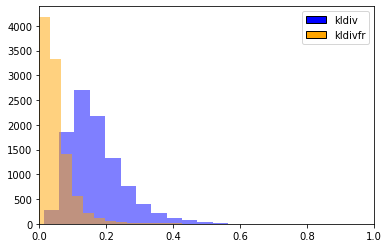

In [11]:

# Implementation of matplotlib function

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
low = "blue"
medium = "orange"
high = "green"
nbin = 100
counts, bins = np.histogram(grad_kldiv,bins=nbin)
plt.hist(bins[:-1], bins, weights=counts, color = low, alpha=0.5)
counts2, bins2 = np.histogram(grad_klfr, bins=nbin)
plt.hist(bins2[:-1], bins2, weights=counts2, color = medium, alpha=0.5)
'''
counts3, bins3 = np.histogram(klfrwdiff, bins=30)
plt.hist(bins3[:-1], bins3, weights=counts, color = high, alpha=0.5)
'''
plt.xlim(0,1)
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium]]
labels= ["kldiv","kldivfr"]
plt.legend(handles, labels)

/tmp/ipykernel_6295/3770396452.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10, hist=True, kde=True,
/tmp/ipykernel_6295/3770396452.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_1k, hist=True, kde=True,
/tmp/ipykernel_6295/3770396452.py:19: UserWarning: 

`distplo

(0.0, 0.25)

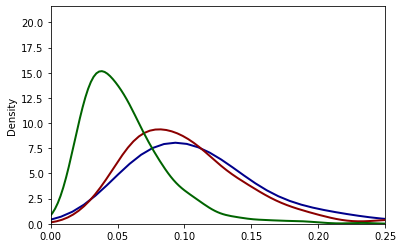

In [17]:
import seaborn as sns

import json
grad_bad_10 = json.loads(open("gradient_klfr_10_bad_sample1000.json").readline())
grad_bad_1k = json.loads(open("gradient_klfr_1k_bad_sample1000.json").readline())
grad_bad_100k = json.loads(open("gradient_klfr_100k_bad_sample1000.json").readline())


sns.distplot(grad_bad_10, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkblue'})

sns.distplot(grad_bad_1k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkred'})

sns.distplot(grad_bad_100k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkgreen'})

plt.xlim(0,0.25)

/tmp/ipykernel_6295/1888943965.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10, hist=True, kde=True,
/tmp/ipykernel_6295/1888943965.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10k, hist=True, kde=True,
/tmp/ipykernel_6295/1888943965.py:19: UserWarning: 

`distpl

(-0.15, 0.25)

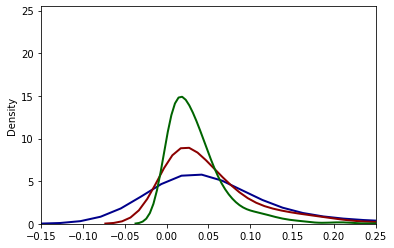

In [18]:
import seaborn as sns

import json
grad_bad_10 = json.loads(open("gradient_klfr_10_good_sample1000.json").readline())
grad_bad_10k = json.loads(open("gradient_klfr_1k_good_sample1000.json").readline())
grad_bad_100k = json.loads(open("gradient_klfr_100k_good_sample1000.json").readline())


sns.distplot(grad_bad_10, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkblue'})

sns.distplot(grad_bad_10k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkred'})

sns.distplot(grad_bad_100k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkgreen'})

plt.xlim(-0.15,0.25)

/tmp/ipykernel_6051/620015970.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10, hist=True, kde=True,
/tmp/ipykernel_6051/620015970.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10k, hist=True, kde=True,
/tmp/ipykernel_6051/620015970.py:19: UserWarning: 

`distplot`

<AxesSubplot:ylabel='Density'>

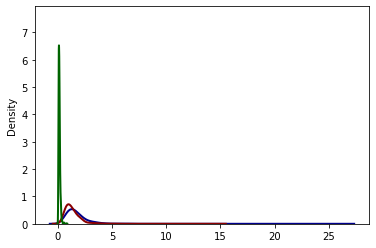

In [21]:
import seaborn as sns

import json
grad_bad_10 = json.loads(open("gradient_kldiv_10_good_sample1000.json").readline())
grad_bad_10k = json.loads(open("gradient_kldiv_1k_good_sample1000.json").readline())
grad_bad_100k = json.loads(open("gradient_kldiv_100k_good_sample1000.json").readline())


sns.distplot(grad_bad_10, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkblue'})

sns.distplot(grad_bad_10k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkred'})

sns.distplot(grad_bad_100k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkgreen'})



/tmp/ipykernel_6051/475903383.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10, hist=True, kde=True,
/tmp/ipykernel_6051/475903383.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_bad_10k, hist=True, kde=True,
/tmp/ipykernel_6051/475903383.py:19: UserWarning: 

`distplot`

<AxesSubplot:ylabel='Density'>

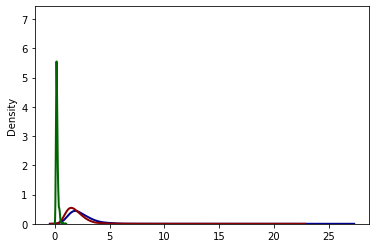

In [22]:
import seaborn as sns

import json
grad_bad_10 = json.loads(open("gradient_kldiv_10_bad_sample1000.json").readline())
grad_bad_10k = json.loads(open("gradient_kldiv_1k_bad_sample1000.json").readline())
grad_bad_100k = json.loads(open("gradient_kldiv_100k_bad_sample1000.json").readline())


sns.distplot(grad_bad_10, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkblue'})

sns.distplot(grad_bad_10k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkred'})

sns.distplot(grad_bad_100k, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": 'darkgreen'})




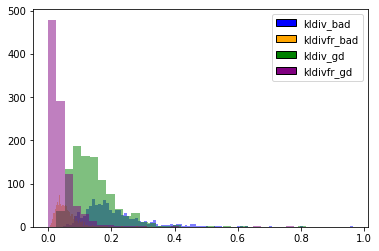

In [3]:

# Implementation of matplotlib function

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
low = "blue"
medium = "orange"
high = "green"
num4 = "purple"
nbin = 100
counts, bins = np.histogram(grad_kldiv,bins=nbin)
plt.hist(bins[:-1], bins, weights=counts, color = low, alpha=0.5)
counts2, bins2 = np.histogram(grad_klfr, bins=nbin)
plt.hist(bins2[:-1], bins2, weights=counts2, color = medium, alpha=0.5)
counts3, bins3 = np.histogram(grad_kldivg, bins=30)
plt.hist(bins3[:-1], bins3, weights=counts3, color = high, alpha=0.5)
counts4, bins4 = np.histogram(grad_klfrg, bins=30)
plt.hist(bins4[:-1], bins4, weights=counts4, color = num4, alpha=0.5)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [low,medium,high,num4]]
labels= ["kldiv_bad","kldivfr_bad","kldiv_gd","kldivfr_gd",]
plt.legend(handles, labels)

/tmp/ipykernel_6051/293175913.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_kldiv, hist=True, kde=True,
/tmp/ipykernel_6051/293175913.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_klfr, hist=True, kde=True,
/tmp/ipykernel_6051/293175913.py:12: UserWarning: 

`distplot` is a

(-0.05, 0.5)

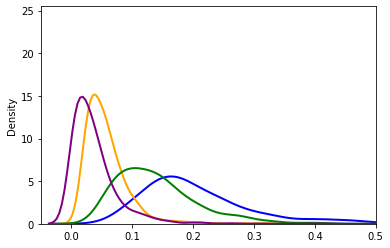

In [10]:
import seaborn as sns
import json
grad_kldiv = json.loads(open("gradient_kldiv_100k_bad_sample1000.json").readline())
#grad_kldiv = gradients
grad_klfr = json.loads(open("gradient_klfr_100k_bad_sample1000.json").readline())
grad_kldivg = json.loads(open("gradient_kldiv_100k_good_sample1000.json").readline())
grad_klfrg = json.loads(open("gradient_klfr_100k_good_sample1000.json").readline())

sns.distplot(grad_kldiv, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": low})

sns.distplot(grad_klfr, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": medium})

sns.distplot(grad_kldivg, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": high})

sns.distplot(grad_klfrg, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": num4})

plt.xlim(-0.05,0.5)

/tmp/ipykernel_6051/3941223143.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_kldiv, hist=True, kde=True,
/tmp/ipykernel_6051/3941223143.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_klfr, hist=True, kde=True,
/tmp/ipykernel_6051/3941223143.py:19: UserWarning: 

`distplot` 

(0.0, 8.0)

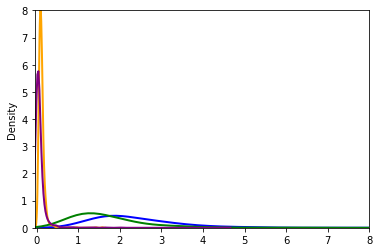

In [16]:
import seaborn as sns
import json
grad_kldiv = json.loads(open("gradient_kldiv_10_bad_sample1000.json").readline())
#grad_kldiv = gradients
grad_klfr = json.loads(open("gradient_klfr_10_bad_sample1000.json").readline())
grad_kldivg = json.loads(open("gradient_kldiv_10_good_sample1000.json").readline())
grad_klfrg = json.loads(open("gradient_klfr_10_good_sample1000.json").readline())

sns.distplot(grad_kldiv, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": low})

sns.distplot(grad_klfr, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": medium})

sns.distplot(grad_kldivg, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": high})

sns.distplot(grad_klfrg, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": num4})

plt.xlim(-0.05,8)
plt.ylim(0,8)

/tmp/ipykernel_6051/3988015098.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_kldiv, hist=True, kde=True,
/tmp/ipykernel_6051/3988015098.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(grad_klfr, hist=True, kde=True,


(0.0, 8.0)

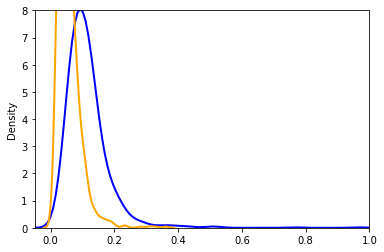

In [19]:
import seaborn as sns
import json
grad_kldiv = json.loads(open("gradient_klfr_10_bad_sample1000.json").readline())
#grad_kldiv = gradients
grad_klfr = json.loads(open("gradient_klfr_100k_bad_sample1000.json").readline())
grad_kldivg = json.loads(open("gradient_klfr_10_good_sample1000.json").readline())
grad_klfrg = json.loads(open("gradient_klfr_100k_good_sample1000.json").readline())

sns.distplot(grad_kldiv, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": low})

sns.distplot(grad_klfr, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2, "color": medium})

'''
sns.distplot(grad_kldiv, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':low},
             kde_kws={'linewidth': 2, "color": low})

sns.distplot(grad_klfr, hist=True, kde=True, 
             bins=nbin, color = 'white', 
             hist_kws={'edgecolor':medium},
             kde_kws={'linewidth': 2, "color": medium})
'''
plt.xlim(-0.05,1)
plt.ylim(0,8)